<a href="https://colab.research.google.com/github/Nick-Azzarano/Machine-Learning-Practice/blob/main/Spring2025/Homeworks/HW7_Azzarano_Nick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nick Azzarano
<br/>
CSCI 335
<br/>
Anton Selitskiy
<br/>
March 24, 2025


# Homework 7: Decision Trees, Bagging, Random Forests
Part1 Decision Tree questions

Part2 Application to the real data

Part 3 Multiclass metrics

## Part 1 (3 pt) Basic elements of decision trees
**Write the code line that calculates the result.**

---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Q 1 (1 pt)** Given that 10 objects have reached a decision tree node, where 8 of them belong to class $C_1$, and 2 belong to class $C_2,$ calculate the impurity of this node, using entropy.

In [2]:
# Given that 10 objects have reached a decision tree node, where 8 of them belong to class  C1 , and 2 belong to class  C2,  calculate the impurity of this node, using entropy.
from math import log2
entropy = -(8/10 * log2(8/10) + 2/10 * log2(2/10))
entropy

0.7219280948873623

**Q2 (1 pt)** Additionally, it is known that the node from the previous task is not a leaf, and it is possible to split it in such a way that all objects of class $C_1$ end up in the left subtree and class $C_2$ objects end up in the right subtree. Calculate the (non-truncated) information gain criterion:

$$
Q = H(V) - \frac{|V_L|}{|V|}H(V_L) - \frac{|V_R|}{|V|}H(V_R).
$$
Now, $H(V)$ is calculated using Gini index:
$$
H(V) = \sum_{k=1}^C p_k(1-p_k),
$$
where $C$ is the number of classes (two in our case).

In [3]:
# Additionally, it is known that the node from the previous task is not a leaf,
# and it is possible to split it in such a way that all objects of class  C1  end
# up in the left subtree and class  C2  objects end up in the right subtree.

# Calculate the (non-truncated) information gain criterion:
# Q= H(V) − ((|VL|/|V|)*H(VL)) − ((|VR|/|V|)*H(VR)).

# Now,  H(V)  is calculated using Gini index:
# H(V)=C∑k=1 ( pk*(1−pk) ), where  C  is the number of classes (two in our case).


# Gini index calculation function
def gini_index(proportions):
    return sum(p * (1 - p) for p in proportions)

# Proportions for the parent node
p1 = 8 / 10  # Proportion of class C1
p2 = 2 / 10  # Proportion of class C2
H_V = gini_index([p1, p2])  # Gini index for the parent node

# Proportions for the left and right subtrees
# Left subtree contains all objects of class C1
p1_left = 1  # All objects in the left subtree are class C1
p2_left = 0  # No objects of class C2 in the left subtree
H_VL = gini_index([p1_left, p2_left])  # Gini index for the left subtree

# Right subtree contains all objects of class C2
p1_right = 0  # No objects of class C1 in the right subtree
p2_right = 1  # All objects in the right subtree are class C2
H_VR = gini_index([p1_right, p2_right])  # Gini index for the right subtree

# Sizes of the subtrees
V = 10  # Total number of objects
V_L = 8  # Number of objects in the left subtree
V_R = 2  # Number of objects in the right subtree

# Information gain criterion
Q = H_V - (V_L / V) * H_VL - (V_R / V) * H_VR

# Print the results
print(f"H(V): {H_V}")
print(f"H(V_L): {H_VL}")
print(f"H(V_R): {H_VR}")
print(f"Information Gain Criterion (Q): {Q}")

H(V): 0.32
H(V_L): 0
H(V_R): 0
Information Gain Criterion (Q): 0.32


**Q3 (1 pt)** During the tree construction using MAE metric for impurity (a regression problem is being solved), a leaf node is formed with 10 objects, and the values of the target variable for these objects are as follows: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]. What will be the model's predictions for these objects?

In [4]:
# Target variable values for the leaf node
values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]

# Calculate the median
prediction = np.median(values)

# Print the prediction
print(f"The model's prediction for the leaf node is: {prediction}")

The model's prediction for the leaf node is: 38.5


## Part 2: (12 pt) Bagging and Random Forest
We well work with the dataset from HW6. Just run all the cells below to cteate data for training and evaluation.

---

In [5]:
#m=pd.read_csv(path+'Members.csv',index_col='MemberID')
m=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/Members.csv',index_col='MemberID')
m.head()

,AgeAtFirstClaim,Sex
MemberID,,
14723353,70-79,M
75706636,70-79,M
17320609,70-79,M
69690888,40-49,M
33004608,0-9,M


In [6]:
#claims=pd.read_csv(path+'Claims_Y1.csv',index_col='MemberID')
claims=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/Claims.csv',index_col='MemberID')
#claims.head()

In [7]:
#days2=pd.read_csv(path+'DaysInHospital_Y2.csv',index_col='MemberID')
days2=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/DaysInHospital_Y2.csv',index_col='MemberID')
#days2.head()

In [8]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s.split('-')[0]) if s!='80+' else 80)

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

<ipython-input-8-a189b6f0acbb>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)


In [9]:
f_Charlson = claims.groupby(['MemberID'])['CharlsonIndex'].max()
f_LengthOfStay = claims.groupby(['MemberID'])['LengthOfStay'].sum()

In [11]:
y = (days2['DaysInHospital']>0).astype('int').values
X = days2[['ClaimsTruncated']]
X = X.join(f_Charlson)
X = X.join(f_LengthOfStay)
X = X.join(m.AgeAtFirstClaim)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim
MemberID,,,,
24027423,0,3,0,30
98324177,0,0,0,30
33899367,1,0,0,80
5481382,0,0,1,20
69908334,0,1,0,60


In [12]:
X = X.join(m.Sex)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,Sex
MemberID,,,,,
24027423,0,3,0,30,M
98324177,0,0,0,30,M
33899367,1,0,0,80,F
5481382,0,0,1,20,F
69908334,0,1,0,60,F


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [16]:
transform = ColumnTransformer([('OneHot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), ['Sex'])], remainder='passthrough')

In [17]:
transform.fit(X_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='infrequent_if_exist'),
                                 ['Sex'])])

In [18]:
X_train_transformed = pd.DataFrame(transform.transform(X_train),columns=transform.get_feature_names_out())
X_train_transformed.head()

,OneHot__Sex_M,OneHot__Sex_nan,remainder__ClaimsTruncated,remainder__CharlsonIndex,remainder__LengthOfStay,remainder__AgeAtFirstClaim
0,1.0,0.0,0.0,1.0,0.0,50.0
1,0.0,0.0,0.0,0.0,0.0,20.0
2,0.0,0.0,0.0,0.0,0.0,70.0
3,0.0,1.0,0.0,0.0,0.0,50.0
4,1.0,0.0,0.0,1.0,0.0,70.0


In [19]:
X_test_transformed = pd.DataFrame(transform.transform(X_test),columns=transform.get_feature_names_out())
X_test_transformed.head()

,OneHot__Sex_M,OneHot__Sex_nan,remainder__ClaimsTruncated,remainder__CharlsonIndex,remainder__LengthOfStay,remainder__AgeAtFirstClaim
0,0.0,0.0,0.0,0.0,3.0,30.0
1,0.0,0.0,1.0,1.0,1.0,80.0
2,1.0,0.0,0.0,0.0,0.0,40.0
3,0.0,0.0,0.0,0.0,0.0,60.0
4,0.0,0.0,0.0,1.0,0.0,80.0


In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split

**Q4 (4 pt)** On the training set, find the optimal values for the hyperparameters `max_depth` and `min_samples_leaf` for the `DecisionTreeClassifier`. To do this:

(a) Create a dictionary with possible values to iterate over.

(b) Use grid search with cross-validation (we don't use validation set) using the F1-score as the criterion (parameter `scoring` in GridSearchCV).

(c) Choose the pair of values that provides the best quality.

Train the decision tree with the selected hyperparameters on the full training set. Evaluate the classification quality on the test set using Confusion Matrix and metrics recall, and auc_roc.

In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
# On the training set, find the optimal values for the hyperparameters max_depth and min_samples_leaf for the DecisionTreeClassifier.
# (a) Create a dictionary with possible values to iterate over.
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4]
}

In [23]:
# (b) Use grid search with cross-validation (we don't use validation set) using the F1-score as the criterion (parameter scoring in GridSearchCV).
dt = DecisionTreeClassifier(class_weight="balanced")
clf = GridSearchCV(dt, param_grid, scoring='f1')
clf.fit(X_train_transformed, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4]},
             scoring='f1')

In [24]:
# (c) Choose the pair of values that provides the best quality.
print(clf.best_params_)

{'max_depth': 10, 'min_samples_leaf': 1}


In [25]:
# Train the decision tree with the selected hyperparameters on the full training set
clf.best_estimator_.fit(X_train_transformed, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10)

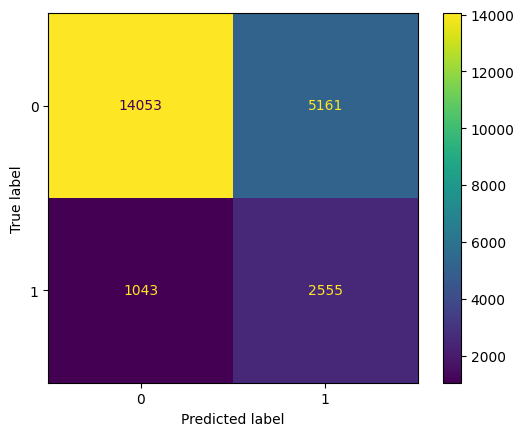

In [26]:
ConfusionMatrixDisplay.from_predictions(y_test, clf.best_estimator_.predict(X_test_transformed))

In [27]:
recall_score(y_test, clf.best_estimator_.predict(X_test_transformed))

0.7101167315175098

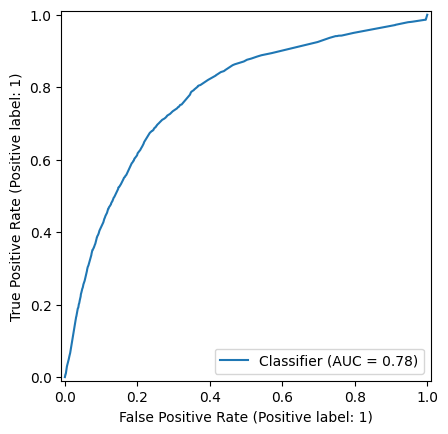

In [28]:
RocCurveDisplay.from_predictions(y_test, clf.best_estimator_.predict_proba(X_test_transformed)[:,1])

**Q5 (3 pt)** Train [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) with 50 trees on the training set, use parameter `max_samples=0.9`. Estimate the quality using metrics from the previous question.

In [29]:
from sklearn.ensemble import BaggingClassifier

In [31]:
dt2 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, class_weight="balanced")

In [32]:
# Train BaggingClassifier with 50 trees on the training set, use parameter max_samples=0.9.
clf_bag = BaggingClassifier(dt2, n_estimators=50, max_samples=0.9)
clf_bag.fit(X_train_transformed, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   max_depth=10),
                  max_samples=0.9, n_estimators=50)

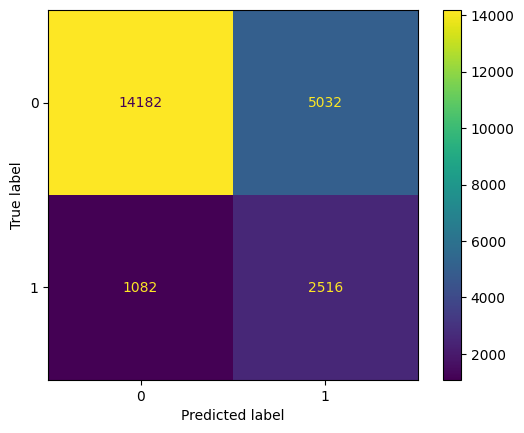

In [34]:
ConfusionMatrixDisplay.from_predictions(y_test, clf_bag.predict(X_test_transformed))

In [35]:
recall_score(y_test, clf_bag.predict(X_test_transformed))

0.6992773763201778

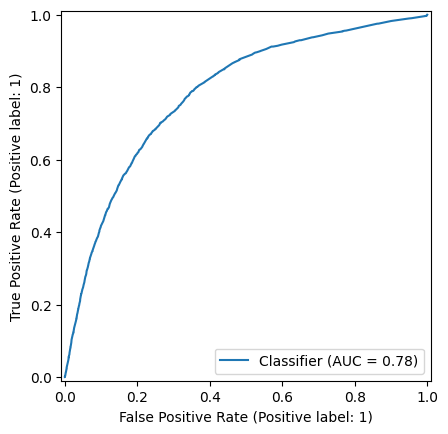

In [36]:
RocCurveDisplay.from_predictions(y_test, clf_bag.predict_proba(X_test_transformed)[:,1])

**Q6 (4 pt)** On the training set, find the optimal values for the hyperparameters `max_depth` and `min_samples_split` for the `Random Forest`. To do this:

(a) Create a dictionary with possible values to iterate over.

(b) Use grid search with cross-validation (we don't use validation set) using the f1-score as the criterion (parameter `scoring="f1"` in GridSearchCV).

(c) Choose the pair of values that provides the best quality.

Train the random forest with the selected hyperparameters on the full training set. Evaluate the classification quality on the test set using Confusion Matrix and metrics recall, and auc_roc.

Which of these models worked better?

In [ ]:
clf_rf = RandomForestClassifier(class_weight='balanced')

In [ ]:
clf_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

**Q7 (1 pt)** For the best model report the most relevant features, parameter `feature_importances_`

## Part 3.
**Q8 (5 pt)** Given the confusion matrix, write the expression that calculates macro- and micro- f1-score. For macro-averaging we calculate f1 for every class and then average. For micro-averaging we average TP, FP, FN and then calculate metrics.

**Write the code that calculates f1-score using the numbers below**

In [ ]:
np.random.seed(42)
y_target = np.random.randint(0, 3, 20)
y_pred = np.random.randint(0, 3, 20)

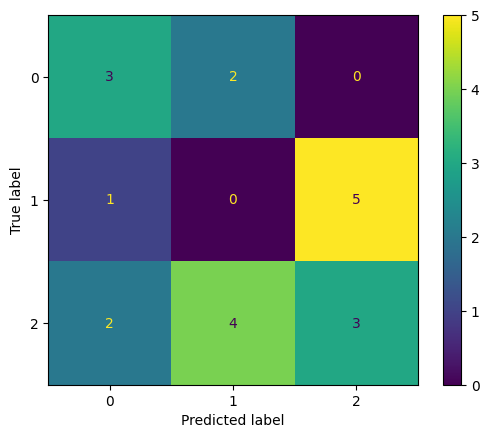

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_target, y_pred)

In [ ]:
#your code and variables like Pr1, Rec1, etc - no buit-in functions
Pr1 =

In [ ]:
f1_macro =

In [ ]:
from sklearn.metrics import make_scorer, f1_score

In [ ]:
assert np.abs(f1_macro-f1_score(y_target, y_pred, average="macro")) < 1e-5

In [ ]:
f1_micro =

In [ ]:
assert np.abs(f1_micro-f1_score(y_target, y_pred, average="micro")) < 1e-5